In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from multiprocessing import Process, Pipe
import time
%matplotlib inline
print(os.listdir("../../data/"))

['init']


In [2]:
jobs = 10

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
structure_df = pd.read_csv('../input/structures.csv')

In [4]:
euclidean_distance = pd.read_pickle('distance.pkl')
h_num = pd.read_pickle('h_num.pkl')

testデータのmolecule_nameがstructureデータに入っているかどうかの確認
→入ってるので、structures.csvのデータは使っても問題なさそうです。

In [5]:
test_molecule = test_df['molecule_name'].unique()
test_molecule_set = set(test_molecule)
structure_molecule = structure_df['molecule_name'].unique()
structure_molecule_set = set(structure_molecule)
test_molecule_set.issubset(structure_molecule_set)

True

In [6]:
train_df = pd.concat([train_df, pd.DataFrame(data=euclidean_distance, columns=['euclidean_distance']),
                                pd.DataFrame(data=h_num, columns=['h_num'])], axis=1)

In [7]:
train_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,euclidean_distance,h_num
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1.091953,4.0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,1.783120,4.0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,1.783147,4.0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,1.783157,4.0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1.091952,4.0


In [8]:
structure_df.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [9]:
train_column = train_df.columns
train_column

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'euclidean_distance', 'h_num'],
      dtype='object')

In [10]:
type_name = train_df['type'].unique()
type_name

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

In [11]:
molecule_name = train_df['molecule_name'].unique()
molecule_name

array(['dsgdb9nsd_000001', 'dsgdb9nsd_000002', 'dsgdb9nsd_000003', ...,
       'dsgdb9nsd_133881', 'dsgdb9nsd_133882', 'dsgdb9nsd_133884'],
      dtype=object)

In [12]:
jhc_1 = train_df[train_df['type']==type_name[0]]
jhh_2 = train_df[train_df['type']==type_name[1]]
jhn_1 = train_df[train_df['type']==type_name[2]]
jhn_2 = train_df[train_df['type']==type_name[3]]
jhc_2 = train_df[train_df['type']==type_name[4]]
jhh_3 = train_df[train_df['type']==type_name[5]]
jhc_3 = train_df[train_df['type']==type_name[6]]
jhn_3 = train_df[train_df['type']==type_name[7]]

In [13]:
jhc_1.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,euclidean_distance,h_num
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1.091953,4.0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1.091952,4.0
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,1.091946,4.0
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,1.091948,4.0
17,17,dsgdb9nsd_000005,2,0,1JHC,171.2200,1.066598,1.0


type別の数

type: 1JHC  number:   709416
type: 2JHH  number:   378036
type: 1JHN  number:    43363
type: 2JHN  number:   119253
type: 2JHC  number:  1140674
type: 3JHH  number:   590611
type: 3JHC  number:  1510379
type: 3JHN  number:   166415


<BarContainer object of 8 artists>

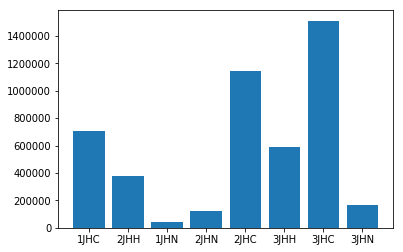

In [14]:
type_num = np.array([jhc_1.shape[0],jhh_2.shape[0],jhn_1.shape[0],jhn_2.shape[0],
                      jhc_2.shape[0],jhh_3.shape[0],jhc_3.shape[0],jhn_3.shape[0]])
for i in range(len(type_num)):
    print("type: {0}  number: {1:8d}".format(type_name[i], type_num[i]))
plt.bar(type_name, type_num)

In [20]:
min(train_df[train_column[5]])

-36.2186

type別にscalar_coupling_constantのヒストグラムを表示しました。
全体的にそんなにscalar_coupling_constantの値のばらつきはないようです。

(array([2.90000e+01, 9.69800e+03, 1.03678e+05, 3.07220e+04, 1.58100e+04,
        4.35500e+03, 1.60600e+03, 4.24000e+02, 8.50000e+01, 8.00000e+00]),
 array([-3.17241 , -1.758049, -0.343688,  1.070673,  2.485034,  3.899395,
         5.313756,  6.728117,  8.142478,  9.556839, 10.9712  ]),
 <a list of 10 Patch objects>)

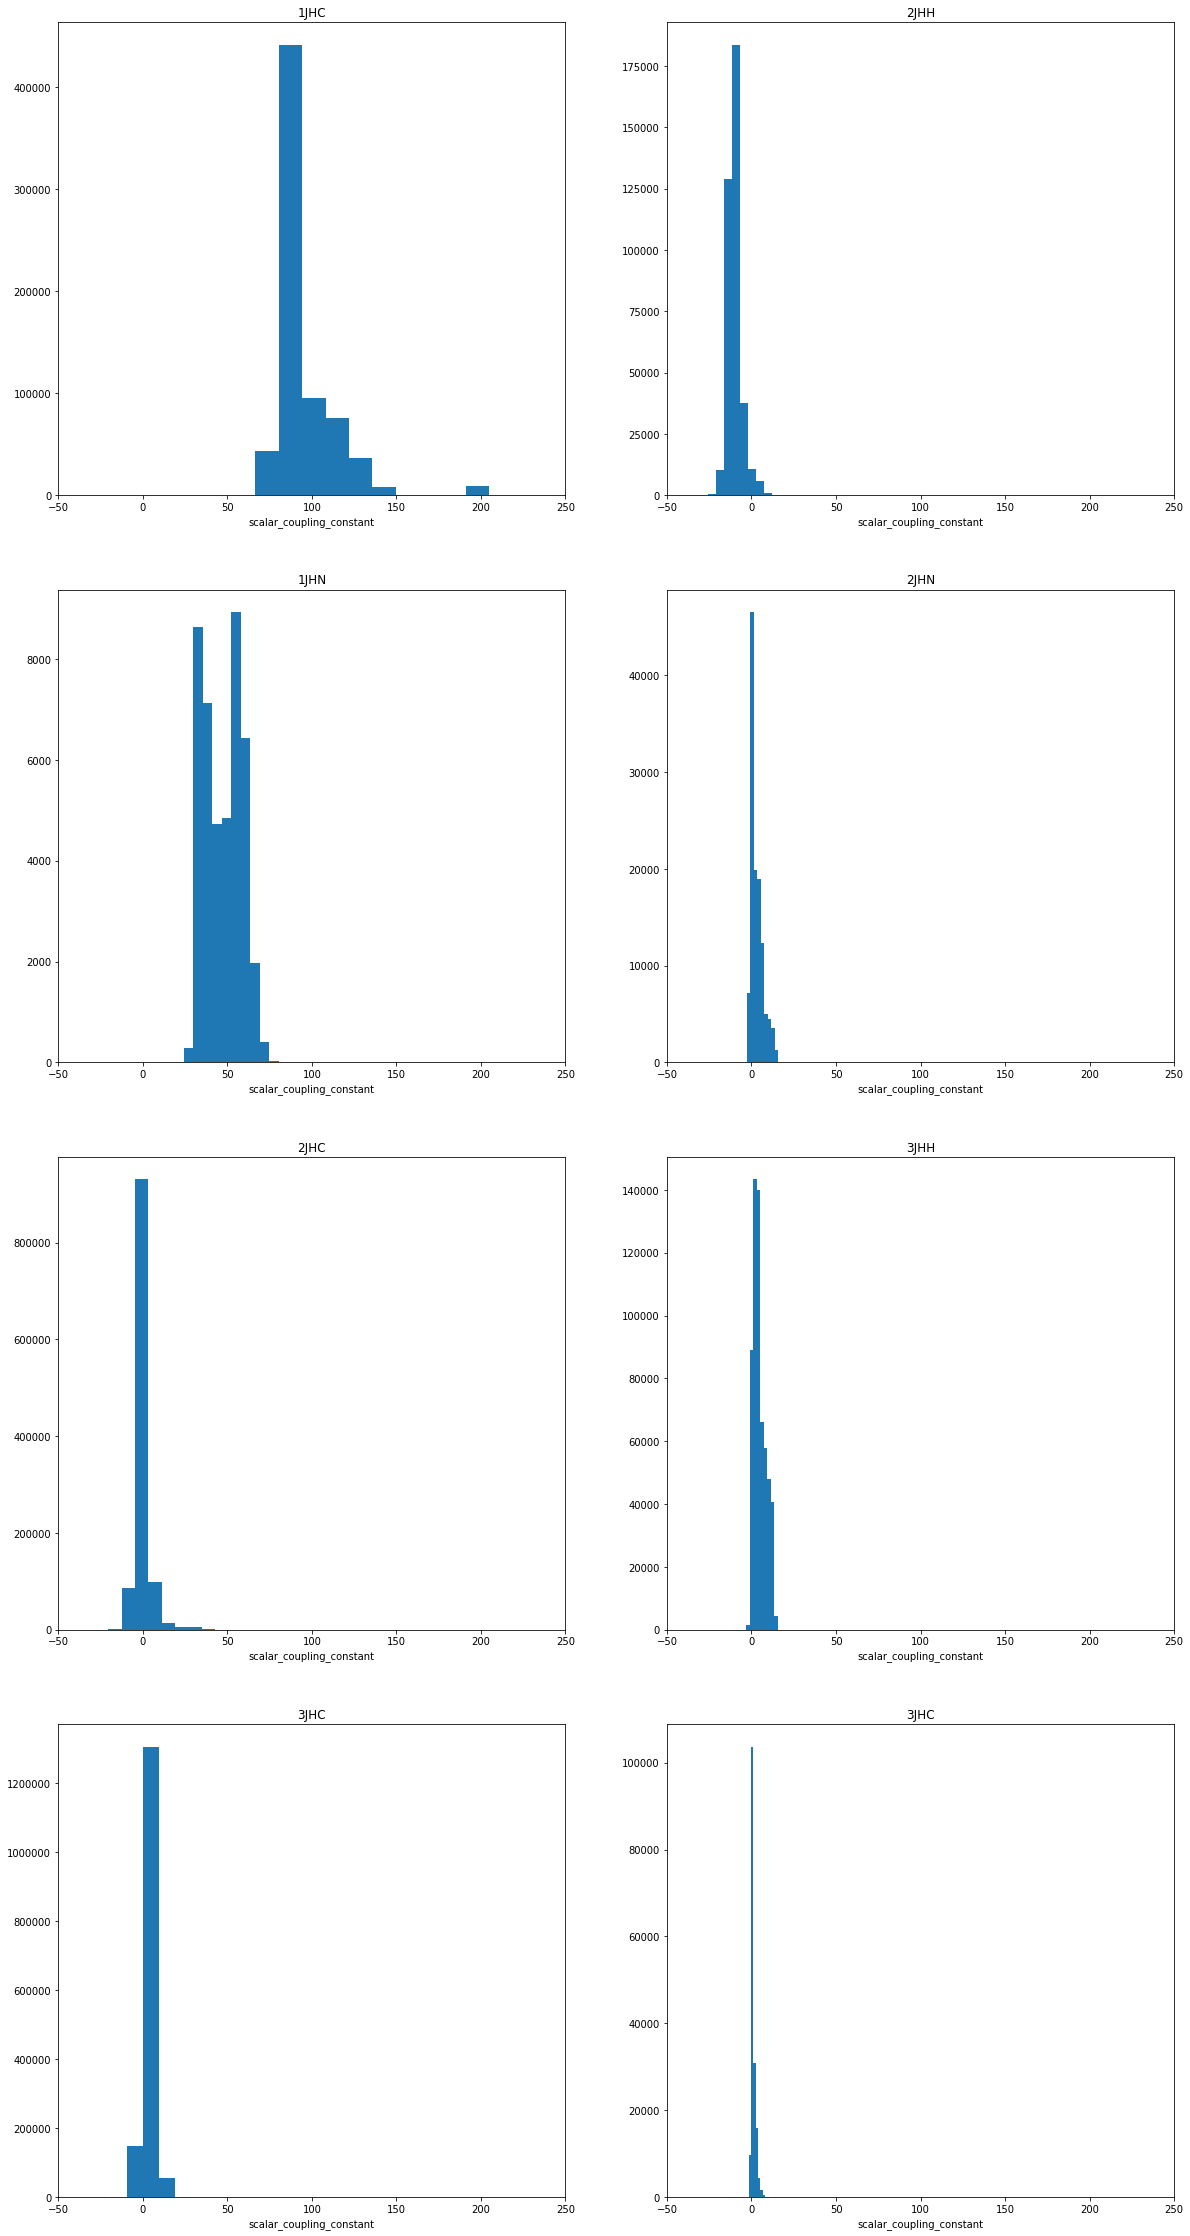

In [23]:
plt.figure(figsize=(20,40))
plt.subplot(4,2,1)
plt.title('1JHC')
plt.xlabel('scalar_coupling_constant')
plt.xlim(-50,250)
plt.hist(jhc_1[train_column[5]])
plt.subplot(4,2,2)
plt.title('2JHH')
plt.xlabel('scalar_coupling_constant')
plt.xlim(-50,250)
plt.hist(jhh_2[train_column[5]])
plt.subplot(4,2,3)
plt.title('1JHN')
plt.xlabel('scalar_coupling_constant')
plt.xlim(-50,250)
plt.hist(jhn_1[train_column[5]])
plt.subplot(4,2,4)
plt.title('2JHN')
plt.xlabel('scalar_coupling_constant')
plt.xlim(-50,250)
plt.hist(jhn_2[train_column[5]])
plt.subplot(4,2,5)
plt.title('2JHC')
plt.xlabel('scalar_coupling_constant')
plt.xlim(-50,250)
plt.hist(jhc_2[train_column[5]])
plt.subplot(4,2,6)
plt.title('3JHH')
plt.xlabel('scalar_coupling_constant')
plt.xlim(-50,250)
plt.hist(jhh_3[train_column[5]])
plt.subplot(4,2,7)
plt.title('3JHC')
plt.xlabel('scalar_coupling_constant')
plt.xlim(-50,250)
plt.hist(jhc_3[train_column[5]])
plt.subplot(4,2,8)
plt.title('3JHC')
plt.xlabel('scalar_coupling_constant')
plt.xlim(-50,250)
plt.hist(jhn_3[train_column[5]])

euclidean distance(type別に色分け)とscalar_coupling_constantの相関（type別ではなく全体の相関）を表示しました。-0.67ぐらい...

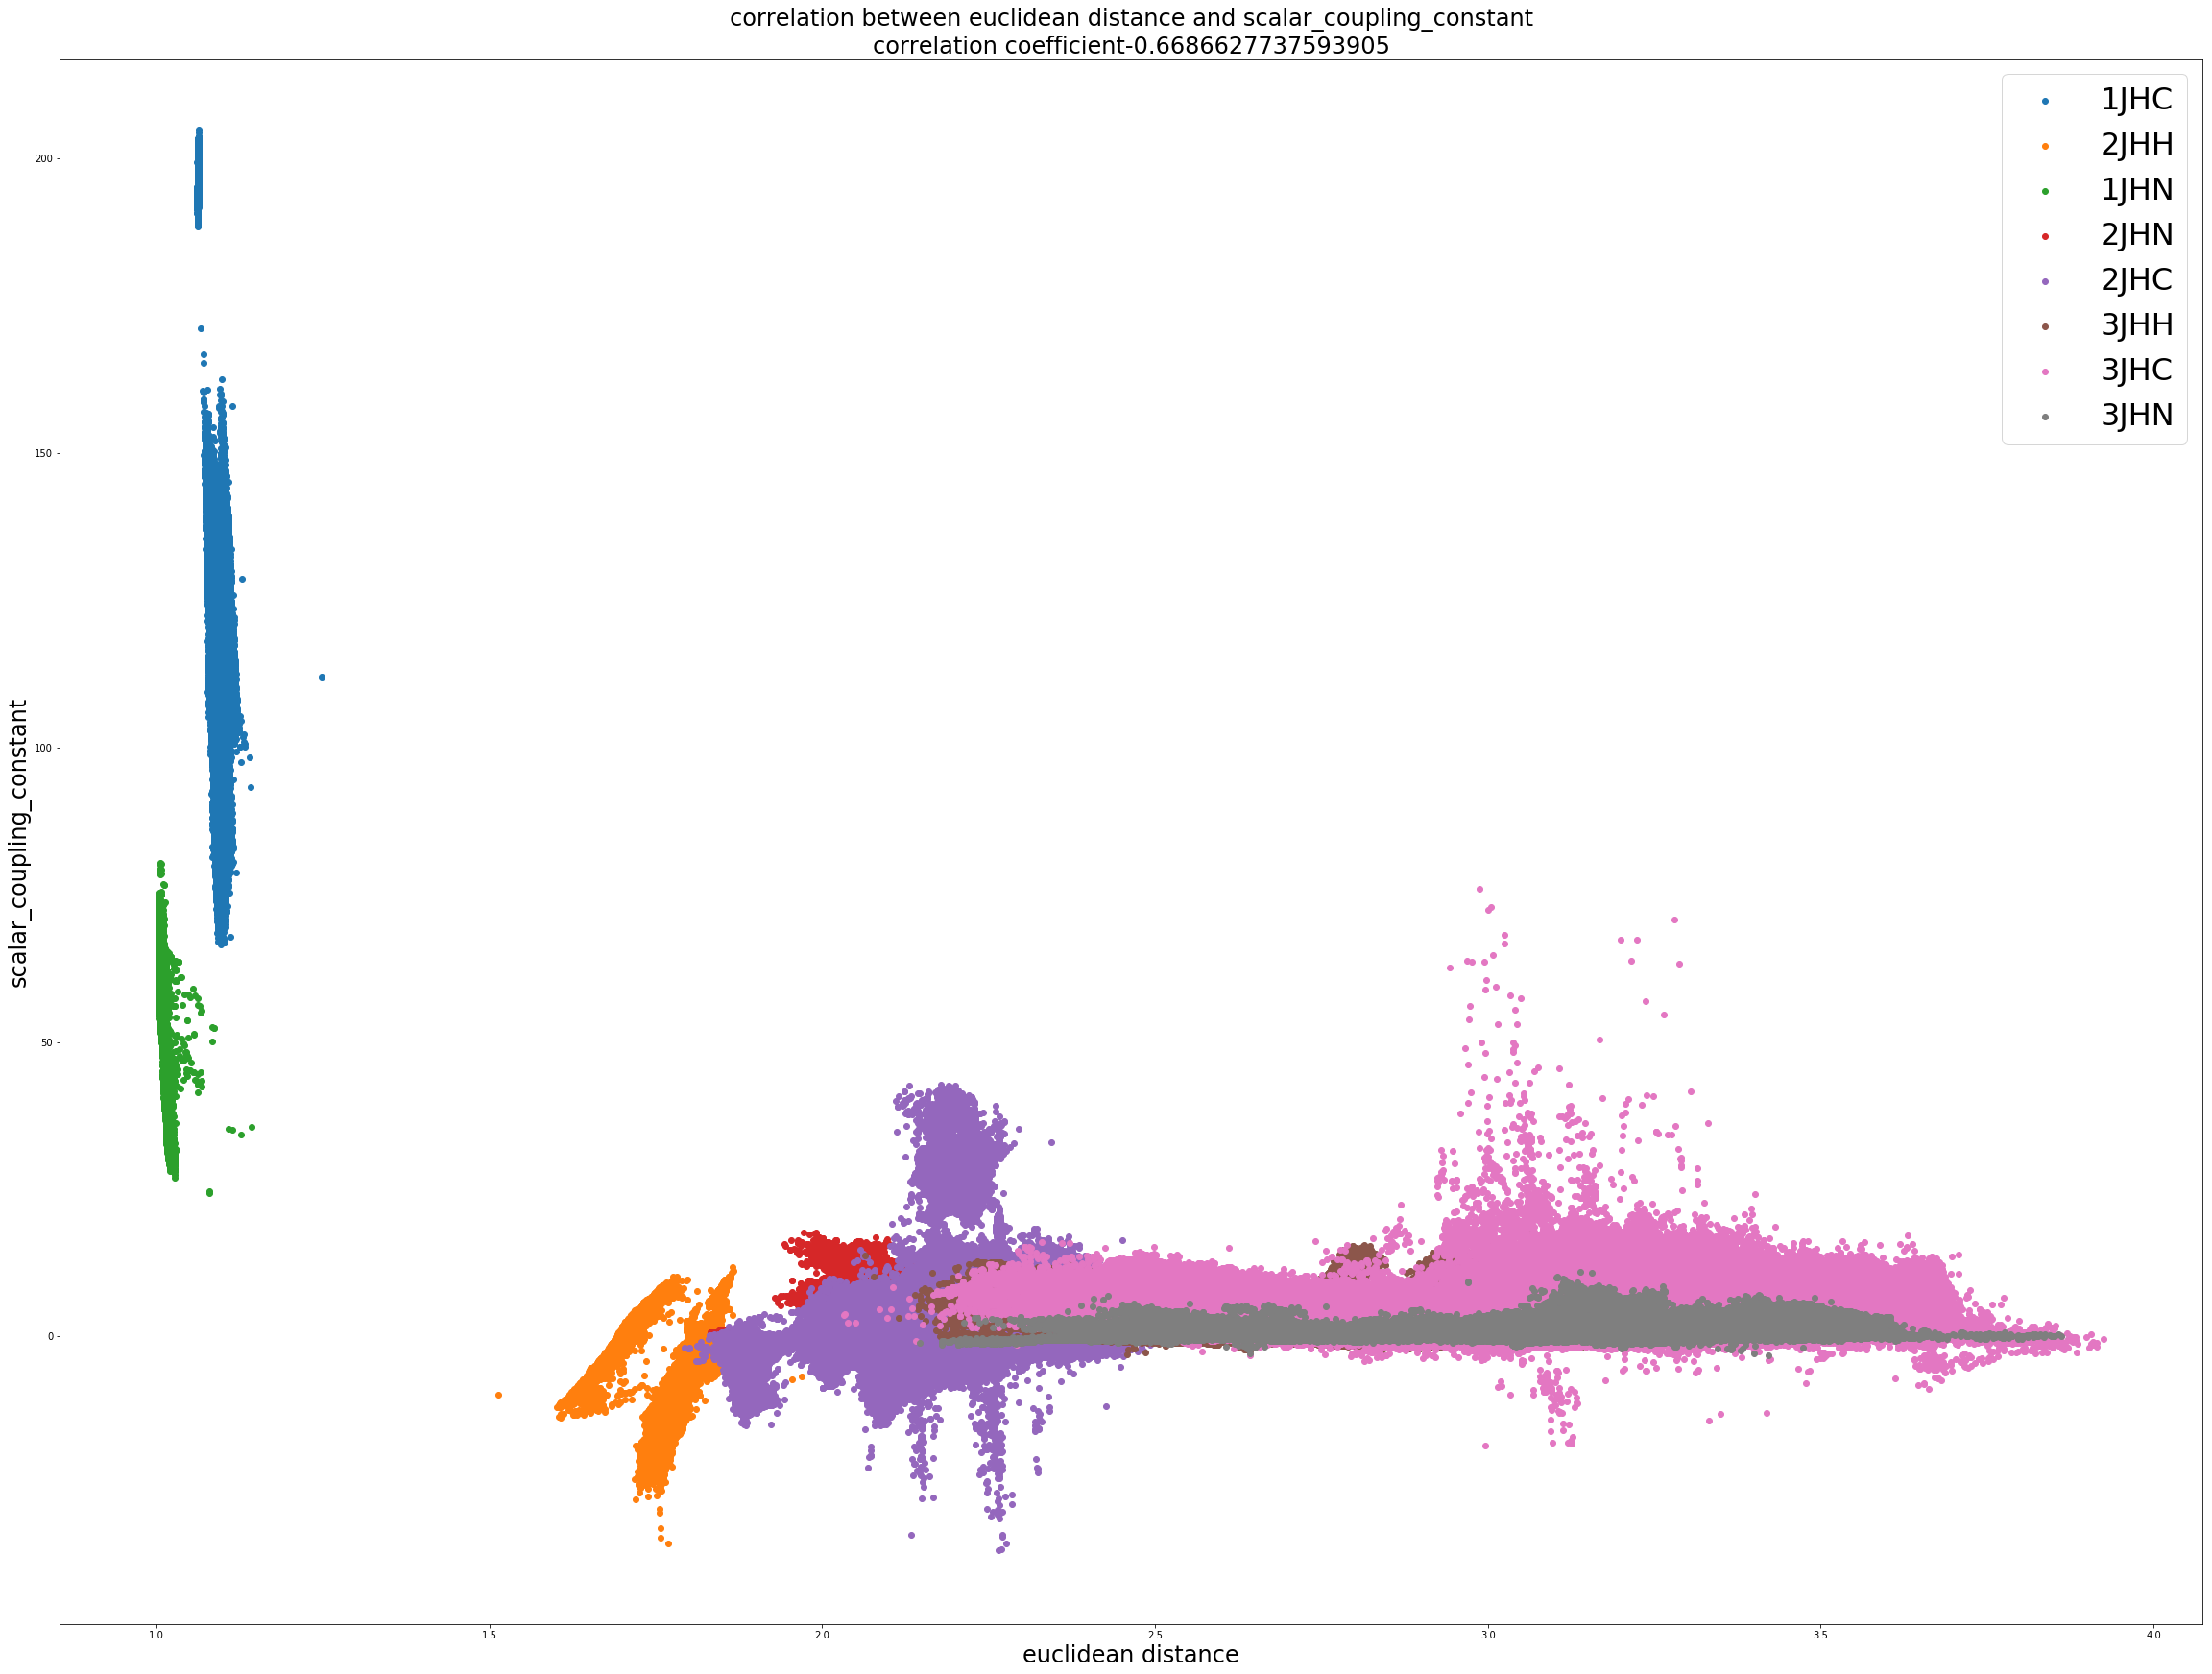

In [16]:
plt.figure(figsize=(40,30))
plt.scatter(jhc_1[train_column[6]],jhc_1[train_column[5]])
plt.scatter(jhh_2[train_column[6]],jhh_2[train_column[5]])
plt.scatter(jhn_1[train_column[6]],jhn_1[train_column[5]])
plt.scatter(jhn_2[train_column[6]],jhn_2[train_column[5]])
plt.scatter(jhc_2[train_column[6]],jhc_2[train_column[5]])
plt.scatter(jhh_3[train_column[6]],jhh_3[train_column[5]])
plt.scatter(jhc_3[train_column[6]],jhc_3[train_column[5]])
plt.scatter(jhn_3[train_column[6]],jhn_3[train_column[5]])
plt.title('correlation between euclidean distance and scalar_coupling_constant\ncorrelation coefficient'+
          str(np.corrcoef(train_df[train_column[5]], train_df[train_column[6]])[0][1]),fontsize=24)
plt.xlabel('euclidean distance',fontsize=24)
plt.ylabel('scalar_coupling_constant',fontsize=24)
plt.legend(['1JHC','2JHH','1JHN','2JHN','2JHC','3JHH','3JHC','3JHN'],fontsize=32)

type別のeuclidean distanceとscalar_coupling_constantの相関を表示しました。

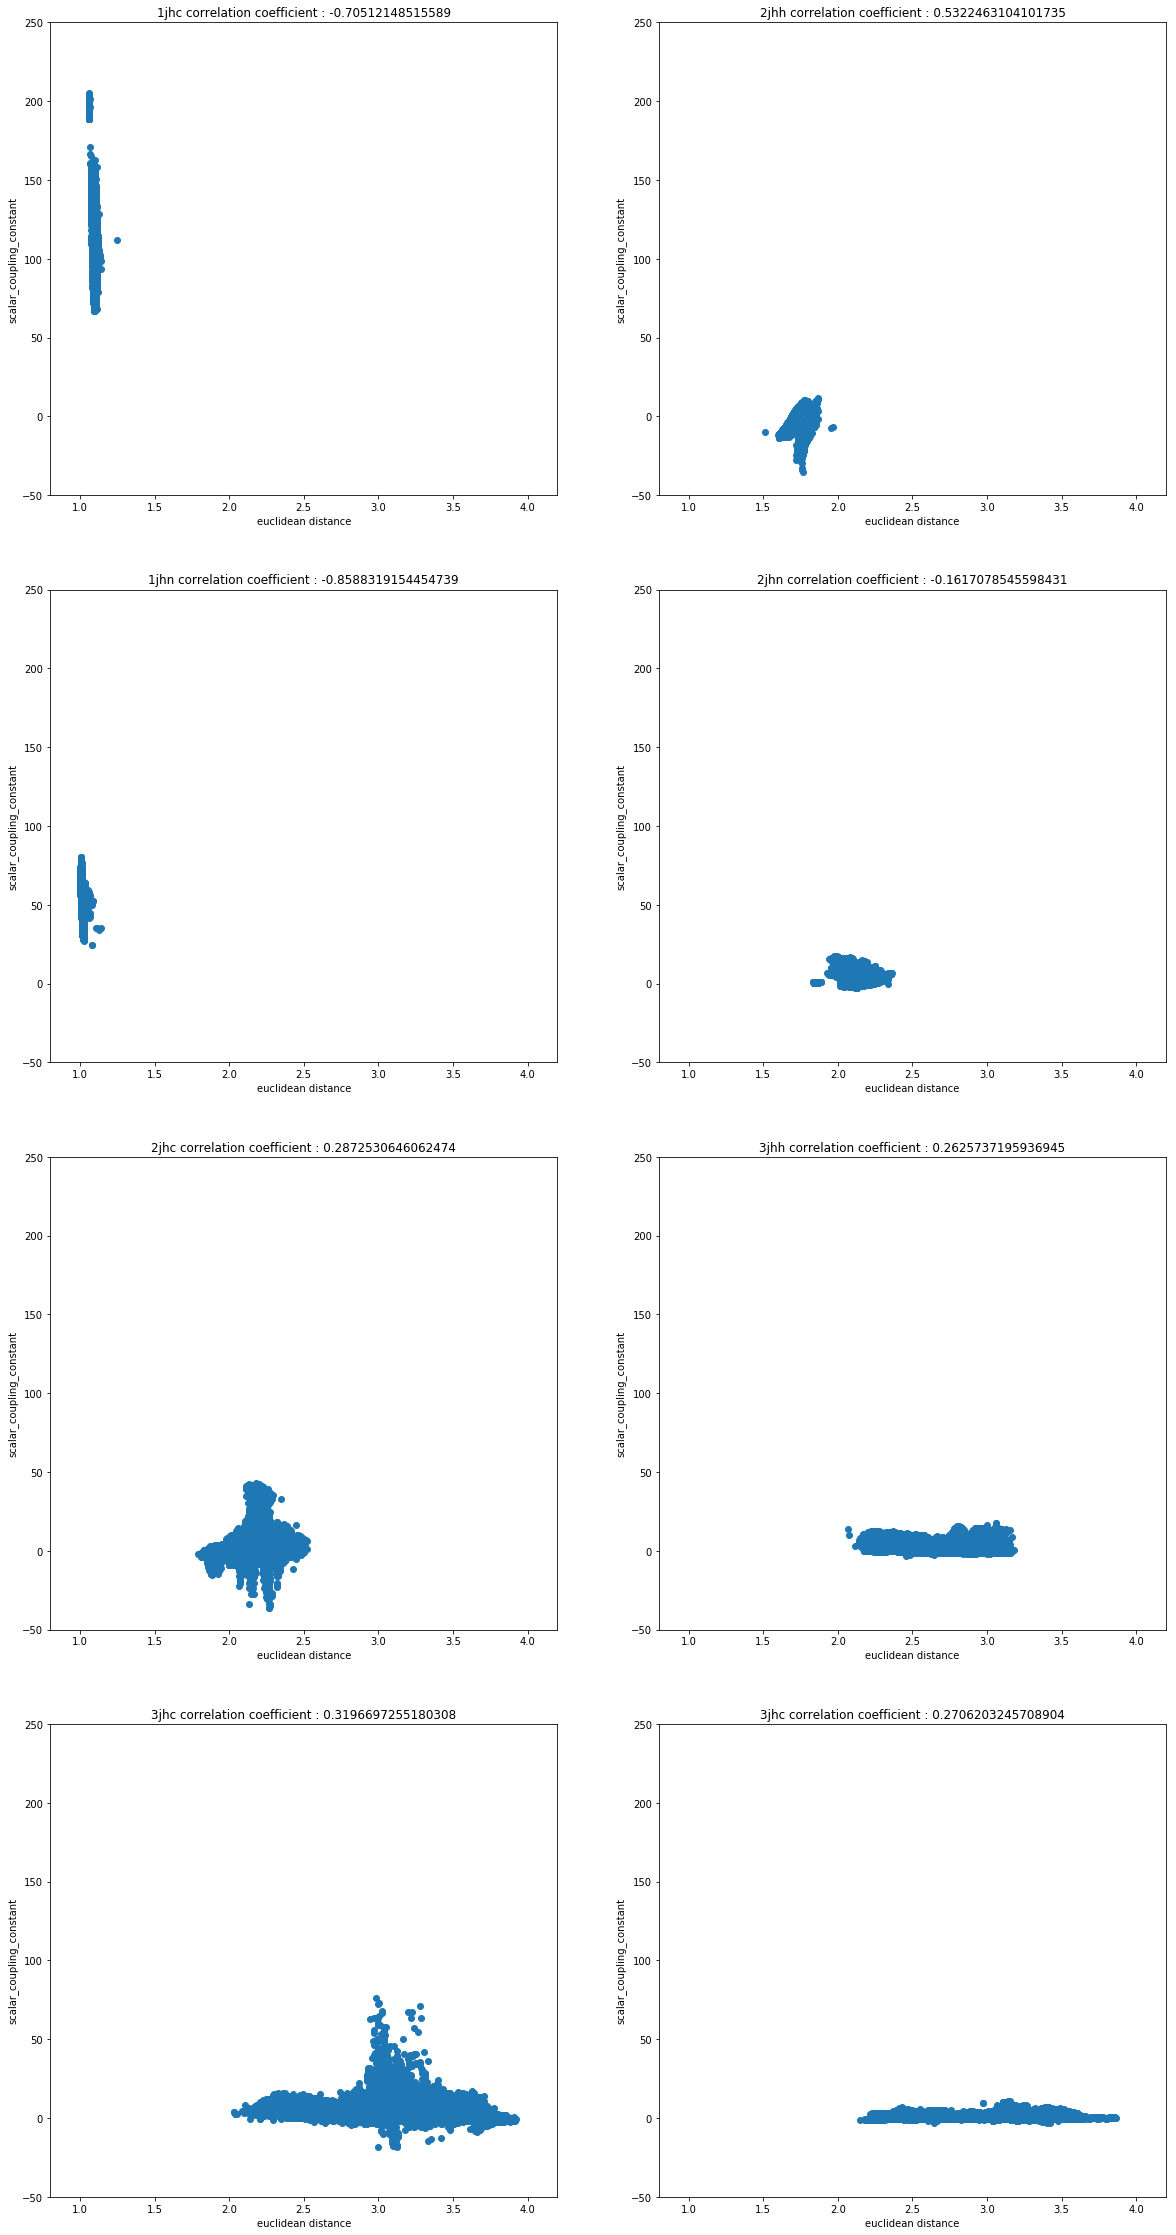

In [17]:
plt.figure(figsize=(20,40))
plt.subplot(4,2,1)
plt.title('1jhc correlation coefficient : '+str(np.corrcoef(jhc_1[train_column[5]], jhc_1[train_column[6]])[0][1]))
plt.xlabel('euclidean distance')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0.8,4.2)
plt.ylim(-50, 250)
plt.scatter(jhc_1[train_column[6]], jhc_1[train_column[5]])
plt.subplot(4,2,2)
plt.title('2jhh correlation coefficient : '+str(np.corrcoef(jhh_2[train_column[5]], jhh_2[train_column[6]])[0][1]))
plt.xlabel('euclidean distance')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0.8,4.2)
plt.ylim(-50, 250)
plt.scatter(jhh_2[train_column[6]], jhh_2[train_column[5]])
plt.subplot(4,2,3)
plt.title('1jhn correlation coefficient : '+str(np.corrcoef(jhn_1[train_column[5]], jhn_1[train_column[6]])[0][1]))
plt.xlabel('euclidean distance')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0.8,4.2)
plt.ylim(-50, 250)
plt.scatter(jhn_1[train_column[6]], jhn_1[train_column[5]])
plt.subplot(4,2,4)
plt.title('2jhn correlation coefficient : '+str(np.corrcoef(jhn_2[train_column[5]], jhn_2[train_column[6]])[0][1]))
plt.xlabel('euclidean distance')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0.8,4.2)
plt.ylim(-50, 250)
plt.scatter(jhn_2[train_column[6]], jhn_2[train_column[5]])
plt.subplot(4,2,5)
plt.title('2jhc correlation coefficient : '+str(np.corrcoef(jhc_2[train_column[5]], jhc_2[train_column[6]])[0][1]))
plt.xlabel('euclidean distance')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0.8,4.2)
plt.ylim(-50, 250)
plt.scatter(jhc_2[train_column[6]], jhc_2[train_column[5]])
plt.subplot(4,2,6)
plt.title('3jhh correlation coefficient : '+str(np.corrcoef(jhh_3[train_column[5]], jhh_3[train_column[6]])[0][1]))
plt.xlabel('euclidean distance')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0.8,4.2)
plt.ylim(-50, 250)
plt.scatter(jhh_3[train_column[6]], jhh_3[train_column[5]])
plt.subplot(4,2,7)
plt.title('3jhc correlation coefficient : '+str(np.corrcoef(jhc_3[train_column[5]], jhc_3[train_column[6]])[0][1]))
plt.xlabel('euclidean distance')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0.8,4.2)
plt.ylim(-50, 250)
plt.scatter(jhc_3[train_column[6]], jhc_3[train_column[5]])
plt.subplot(4,2,8)
plt.title('3jhc correlation coefficient : '+str(np.corrcoef(jhn_3[train_column[5]], jhn_3[train_column[6]])[0][1]))
plt.xlabel('euclidean distance')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0.8,4.2)
plt.ylim(-50, 250)
plt.scatter(jhn_3[train_column[6]], jhn_3[train_column[5]])

Hの数のヒストグラム

(array([   4190.,   54525.,  304833.,  874663., 1383977., 1223826.,
         611141.,  168976.,   28948.,    3068.]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <a list of 10 Patch objects>)

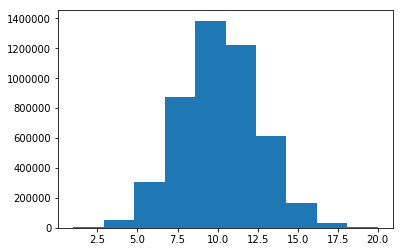

In [13]:
plt.hist(train_df['h_num'])

タイプごとのHの数とscalar_couplingの相関

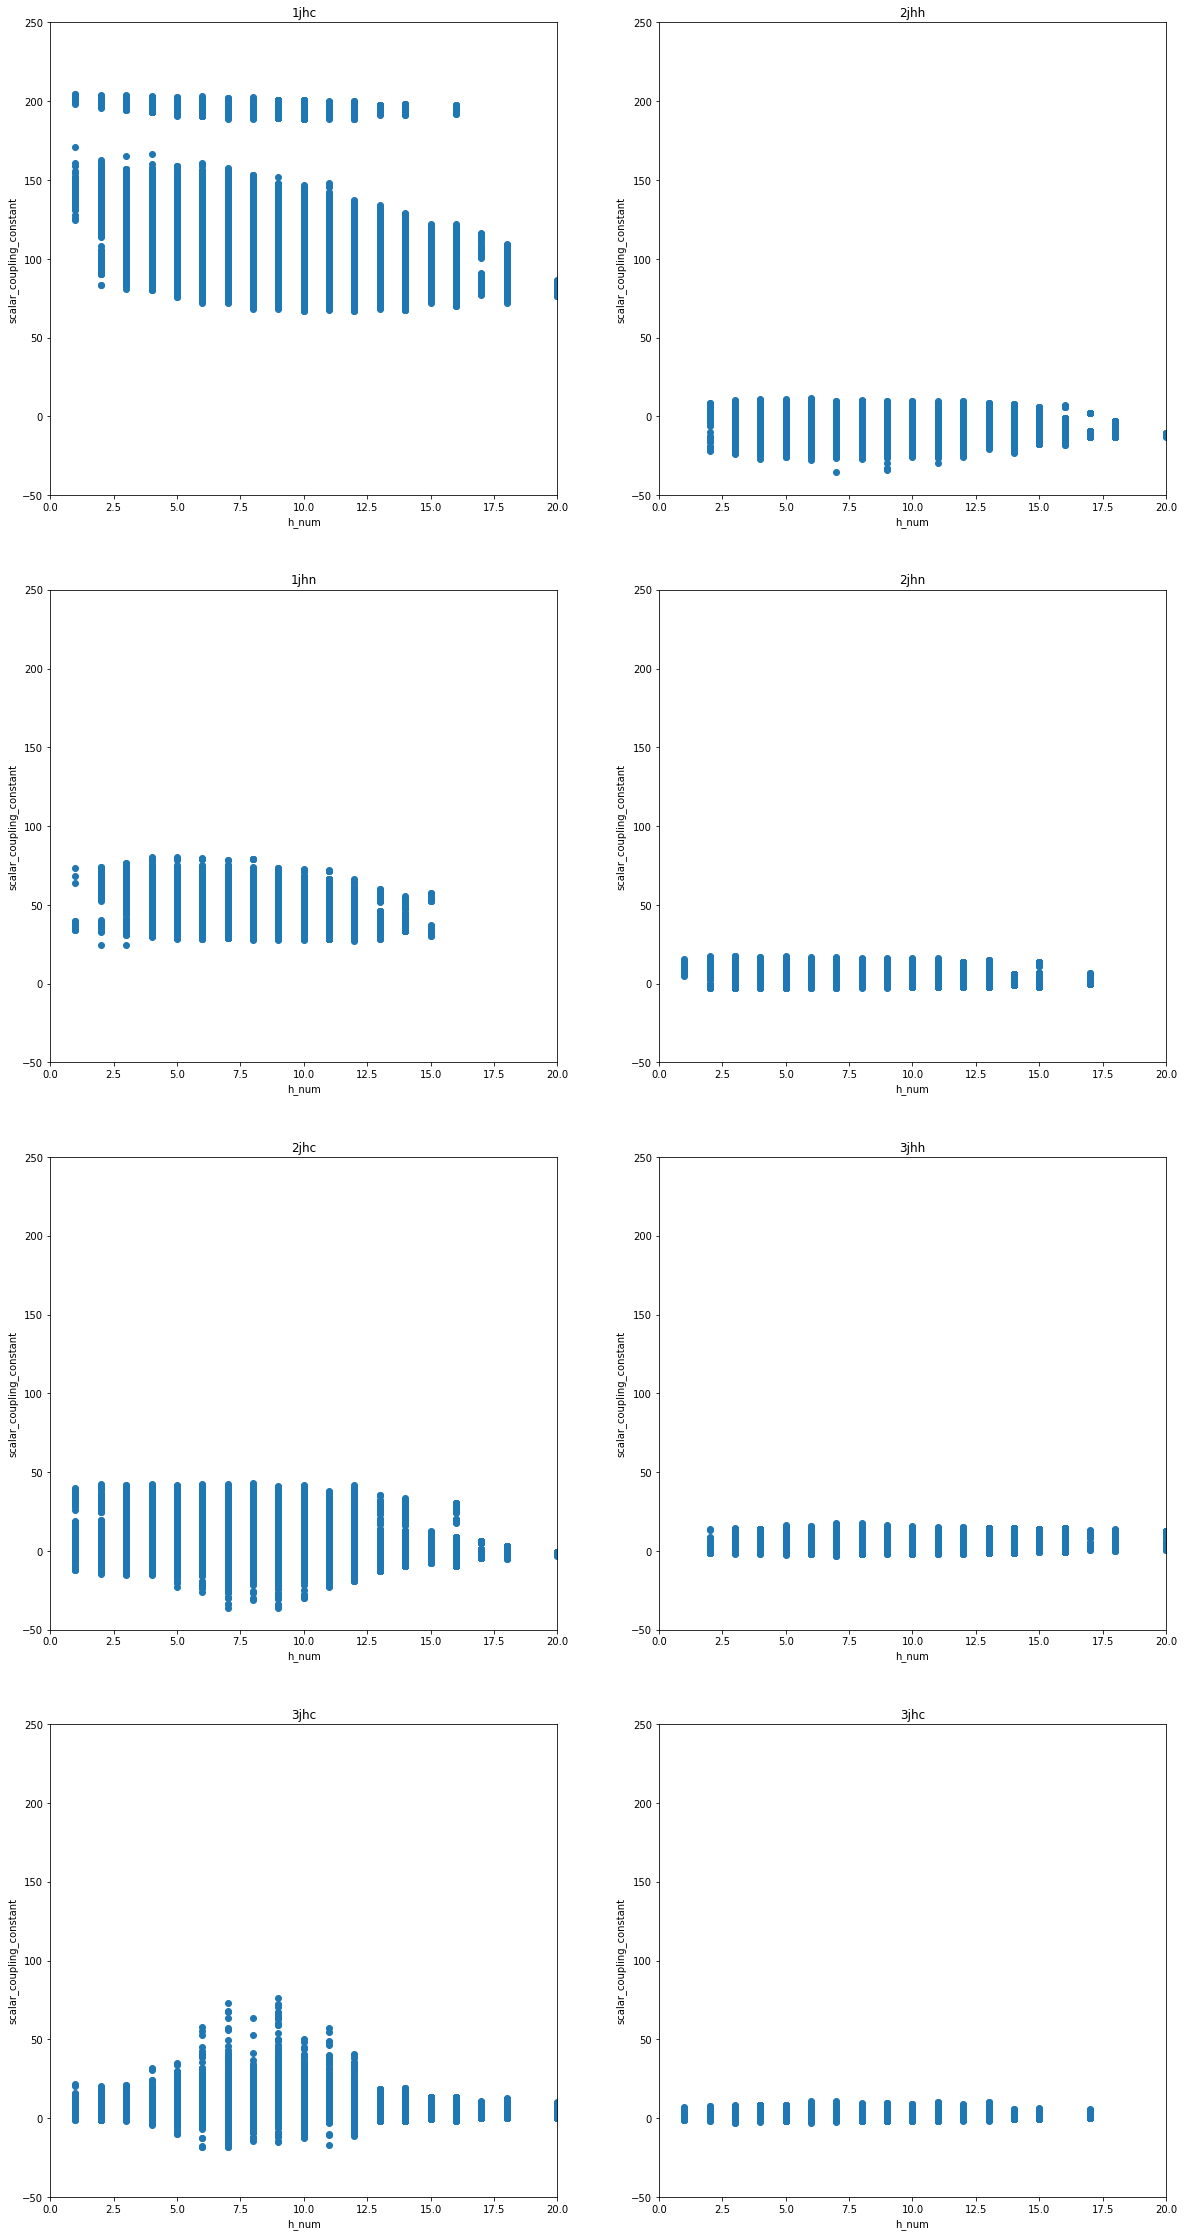

In [18]:
plt.figure(figsize=(20,40))
plt.subplot(4,2,1)
plt.title('1jhc')
plt.xlabel('h_num')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0,20)
plt.ylim(-50, 250)
plt.scatter(jhc_1[train_column[7]], jhc_1[train_column[5]])
plt.subplot(4,2,2)
plt.title('2jhh')
plt.xlabel('h_num')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0,20)
plt.ylim(-50, 250)
plt.scatter(jhh_2[train_column[7]], jhh_2[train_column[5]])
plt.subplot(4,2,3)
plt.title('1jhn')
plt.xlabel('h_num')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0,20)
plt.ylim(-50, 250)
plt.scatter(jhn_1[train_column[7]], jhn_1[train_column[5]])
plt.subplot(4,2,4)
plt.title('2jhn')
plt.xlabel('h_num')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0,20)
plt.ylim(-50, 250)
plt.scatter(jhn_2[train_column[7]], jhn_2[train_column[5]])
plt.subplot(4,2,5)
plt.title('2jhc')
plt.xlabel('h_num')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0,20)
plt.ylim(-50, 250)
plt.scatter(jhc_2[train_column[7]], jhc_2[train_column[5]])
plt.subplot(4,2,6)
plt.title('3jhh')
plt.xlabel('h_num')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0,20)
plt.ylim(-50, 250)
plt.scatter(jhh_3[train_column[7]], jhh_3[train_column[5]])
plt.subplot(4,2,7)
plt.title('3jhc')
plt.xlabel('h_num')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0,20)
plt.ylim(-50, 250)
plt.scatter(jhc_3[train_column[7]], jhc_3[train_column[5]])
plt.subplot(4,2,8)
plt.title('3jhc')
plt.xlabel('h_num')
plt.ylabel('scalar_coupling_constant')
plt.xlim(0,20)
plt.ylim(-50, 250)
plt.scatter(jhn_3[train_column[7]], jhn_3[train_column[5]])

In [3]:
print(os.listdir("../input/"))

['mulliken_charges.csv', 'test.csv', 'structures.csv', 'dipole_moments.csv', 'potential_energy.csv', 'train.csv', 'scalar_coupling_contributions.csv', 'magnetic_shielding_tensors.csv', 'sample_submission.csv']
